In [291]:
import numpy as np
import pandas as pd
import fasttext
from collections import Counter
from tqdm import tqdm
from scipy.sparse import csr_matrix
import math
import operator
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


In [292]:
df_sample = pd.read_csv('datasets/random_sample_data.csv')

In [293]:
# remove unnecessary comments
df_sample = df_sample.drop([x for x in range(len(df_sample)) if int(
    df_sample['label'][x]) != 0 and int(df_sample['label'][x]) != 1])

df_sample.tail()

,raw_comment,tokenized_comment,label
4477,all the flags are sikh religious flags. they d...,all the flag be sikh religious flag they do no...,1
4478,Salute the farmers,salute the farmer,0
4479,Let's also remember how many farmers lost thei...,let be also remember how many farmer lose thei...,0
4480,ABP news you guys dont have heart 8 farmers go...,abp news you guy dont have heart 8 farmer get ...,0
4481,These new laws actually give the power to the ...,these new law actually give the power to the f...,1


In [294]:
comments = df_sample['tokenized_comment']
labels = df_sample['label']

### Weak Supervision

In [295]:
def n_gram_count(sentence: str, n_gram_phrase: str):
    return sentence.count(n_gram_phrase)

### Modified TF-IDF

In [296]:

def IDF(corpus, unique_words):
   idf_dict = {}
   N = len(corpus)
   for i in unique_words:
     count = 0
     for sen in corpus:
       if n_gram_count(sen,i) != 0:
         count = count+1
       idf_dict[i] = (math.log((1+N)/(count+1)))+1
   return idf_dict


def TF(sentence, n_gram_phrase, unique_words):
    """count of t in d / number of words in d

       each phrase in unique_words is considered as a word
    """
    freq = n_gram_count(sentence, n_gram_phrase)
    total_words = len(sentence.split())
    remove = 0
    for word in unique_words:
      freq_word = n_gram_count(sentence, word)
      word_count = freq_word * len(word.split())
      freq_word = word_count - freq_word
      remove += freq_word
    total_words -= remove
    return freq/total_words

def corpus_unique(corpus, n_gram_words):
  """ returns the total unique words in corpus """
  all_sentences = (' '.join(corpus))
  all_words = list(set(all_sentences.split()))
  all_words.extend(n_gram_words)
  
  return list(set(all_words))


In [297]:
n_gram_words = ['punjab', 'bihar']
corpus_words = corpus_unique(list(comments), n_gram_words)

### Make Feature Vector

In [298]:
X = np.zeros((len(df_sample), len(n_gram_words)+1))

comments_list = list(comments)

labels_str = list(labels)
labels_int = [int(i) for i in labels_str]

for i in range(len(comments_list)):
    for j in range(len(n_gram_words)):
        tf_idf_ij = TF(comments_list[i], n_gram_words[j], corpus_words)
        X[i][j] = tf_idf_ij

X[:,-1] = labels_int

In [299]:
X_clean = []
for i in range(len(X)):
    if(X[i][0] != 0 or X[i][1] != 0):
        X_clean.append(list(X[i,:]))

X_clean = np.array(X_clean)

In [300]:
print(len(X_clean))

309


In [301]:
mask = (X_clean[:, -1] == 0)
X_f1 = X_clean[mask, :]

mask = (X_clean[:, -1] == 1)
X_f2 = X_clean[mask, :]


In [302]:
print(len(X_f1), len(X_f2))

115 194


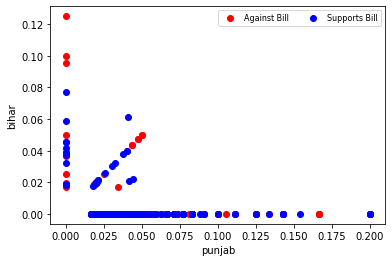

In [303]:
plot_1 = plt.scatter(X_f1[:, 0], X_f1[:, 1], color='red')
plot_2 = plt.scatter(X_f2[:, 0], X_f2[:, 1], color='blue')

plt.legend((plot_1,plot_2), ('Against Bill', 'Supports Bill'), numpoints=1, loc='upper right', ncol=3, fontsize=8)
#plt.title("Stance of Comments based on TF_IDF scores of phrases")
plt.xlabel(n_gram_words[0])
plt.ylabel(n_gram_words[1])
plt.savefig('outputs/figures/' +
            n_gram_words[0]+'_'+n_gram_words[1] + '_'+str(len(X_f1))+'_'+str(len(X_f2)), dpi=300, bbox_inches='tight')
plt.show()

